In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.patches as mpatches

### Analyzing Downs

In [2]:
def analyze_data(filename, distance = 10):
    
    df = pd.read_csv(filename)
    dff = df[df['Down'] == 1]
    dff = dff[((dff['Distance'] == distance) & (dff['Yardline'] >= distance)) | ((dff['Yardline'] < distance) & (dff['Distance'] == dff['Yardline']))]

    dfs = df[df['Down'] == 2]
    dfs = dfs[((dfs['Distance'] == distance) & (dfs['Yardline'] >= distance)) | ((dfs['Yardline'] < distance) & (dfs['Distance'] == dfs['Yardline']))]

    dft = df[df['Down'] == 3]
    dft = dft[((dft['Distance'] == distance) & (dft['Yardline'] >= distance)) | ((dft['Yardline'] < distance) & (dft['Distance'] == dft['Yardline']))]

    dffo = df[df['Down'] == 4]
    dffo = dffo[((dffo['Distance'] == distance) & (dffo['Yardline'] >= distance)) | ((dffo['Yardline'] < distance) & (dffo['Distance'] == dffo['Yardline']))]

    plt.scatter(dff['Yardline'], dff['EP'], alpha=0.6, color='b', label = 'First Down')
    plt.scatter(dfs['Yardline'], dfs['EP'], alpha=0.6, color='y', label = 'Second Down')
    plt.scatter(dft['Yardline'], dft['EP'], alpha=0.6, color='g', label = 'Third Down')
    plt.scatter(dffo['Yardline'], dffo['EP'], alpha=0.6, color='r', label = 'Fourth Down')

    plt.xlabel("Yardline")
    plt.ylabel("Expected Points (EP)")
    plt.title("EP vs. Yardline (Distance = " + str(distance) + ")")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

In [3]:
def compare_eps(file1, file2, down=1, distance=10, label1 = 'Simulated EPs', label2 = 'NFLFastR EPs'):
    df_sim = pd.read_csv(file1)
    df_real = pd.read_csv(file2)

    df_sim = df_sim[df_sim['Down'] == down]
    df_sim = df_sim[((df_sim['Distance'] == distance) & (df_sim['Yardline'] >= distance)) | ((df_sim['Yardline'] < distance) & (df_sim['Distance'] == df_sim['Yardline']))]

    df_real = df_real[df_real['Down'] == down]
    df_real = df_real[((df_real['Distance'] == distance) & (df_real['Yardline'] >= distance)) | ((df_real['Yardline'] < distance) & (df_real['Distance'] == df_real['Yardline']))]

    plt.scatter(df_sim['Yardline'], df_sim['EP'], alpha=0.6, color = 'b', label = label1)
    plt.scatter(df_real['Yardline'], df_real['EP'], alpha=0.6, color='r', label = label2)

    plt.xlabel("Yardline")
    plt.ylabel("Expected Points (EP)")
    plt.title("EP vs. Yardline (" + str(down) + "-" + str(distance) + ")")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

In [4]:
def predicted_decisions(filename, down=4):
    dfo = pd.read_csv(filename)
    dfo = dfo[dfo['Down']==down]

    colors = {0: 'gray', 1: 'blue', 2: 'green', 3: 'red'}
    plt.figure(figsize=(15, 8))
    plt.scatter(dfo['Yardline'], dfo['Distance'], c=dfo['Optimal Choice'].map(colors), edgecolors='black', alpha=0.6)
    plt.yticks(range(1, 21))
    plt.title('Decisions Based on EP, Down='+str(down))
    plt.xlabel('Yard Line')
    plt.ylabel('Distance')
    plt.gca().invert_yaxis()

    labels = {0: 'Run', 1: 'Pass', 2: 'Kick', 3: 'Punt'}  # Use dictionary instead of list
    legend_patches = [mpatches.Patch(color=color, label=labels[choice]) for choice, color in colors.items()]
    plt.legend(handles=legend_patches, title="Optimal Choice")

In [5]:
def ep_visualizer(filename, down=1):
    dfo = pd.read_csv(filename)
    dfo = dfo[dfo['Down']==down]
    dfo = dfo[(dfo['Down']==down) & ~(dfo['Distance'] > dfo['Yardline']) & (dfo['Distance'] <= 20)]

    sc = plt.scatter(
        dfo['Yardline'], dfo['Distance'], c=dfo['EP'], cmap='inferno', edgecolors='black', alpha=0.6
    )

    cbar = plt.colorbar(sc)
    cbar.set_label("Expected Points (EP)")
    plt.yticks(range(1, 21))
    plt.gca().invert_yaxis()

    # Titles and labels
    plt.title('Expected Points, Down='+str(down))
    plt.xlabel('Yard Line')
    plt.ylabel('Distance')

### Naive EP Calculations

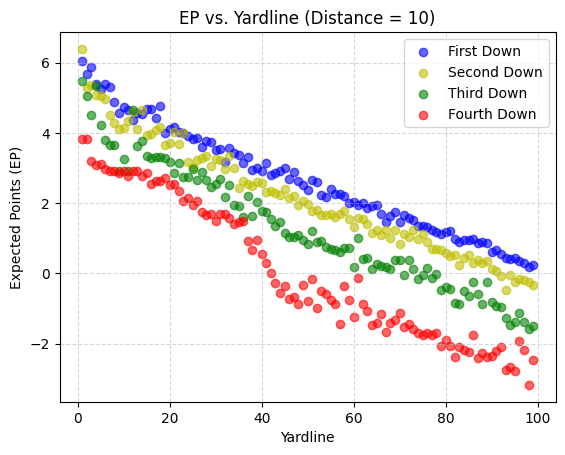

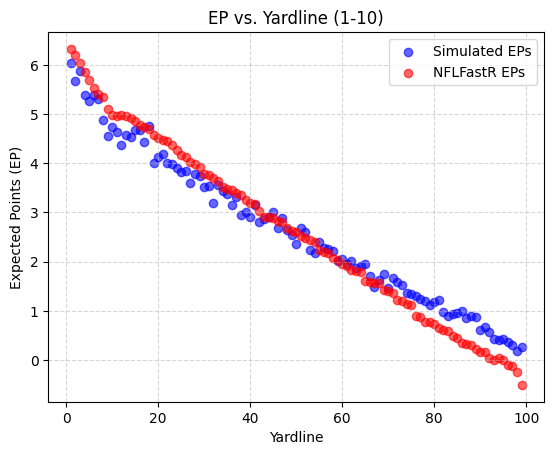

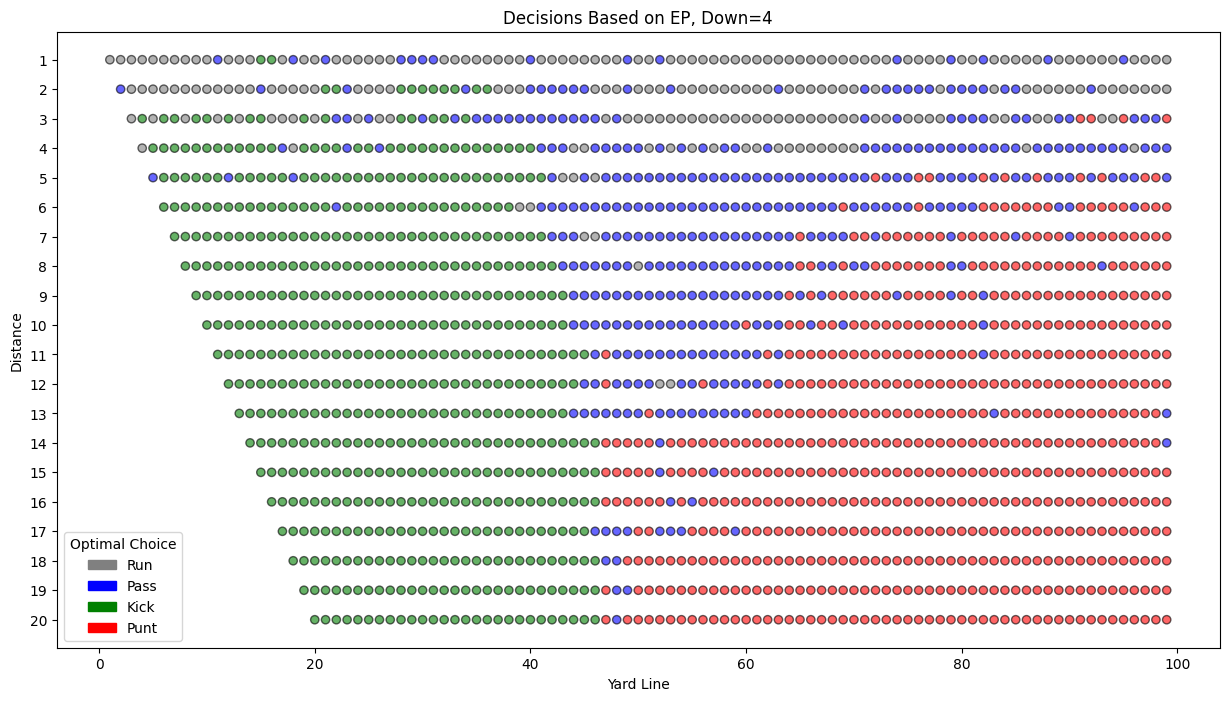

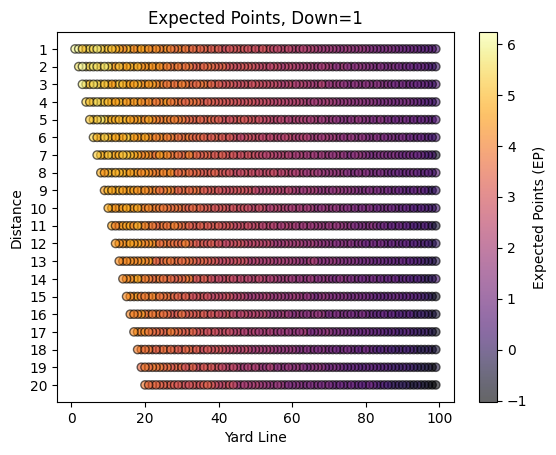

In [6]:
analyze_data('naive_eps/max_eps.csv')
plt.show()
compare_eps('naive_eps/max_eps.csv', 'nfl_pbp_data.csv')
plt.show()
predicted_decisions('naive_eps/opt_choices.csv')
plt.show()
ep_visualizer('naive_eps/max_eps.csv')
plt.show()

### EP Calculations After Three Propegations

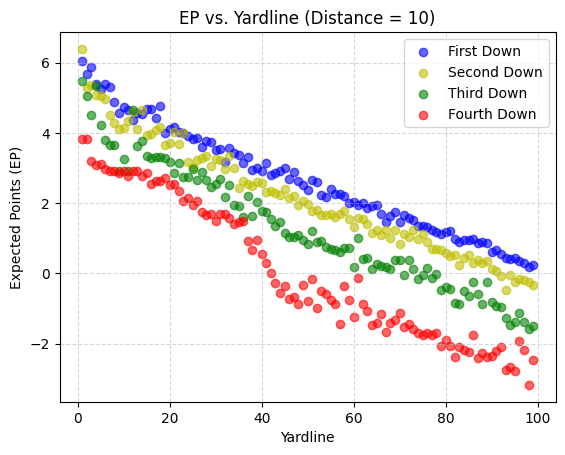

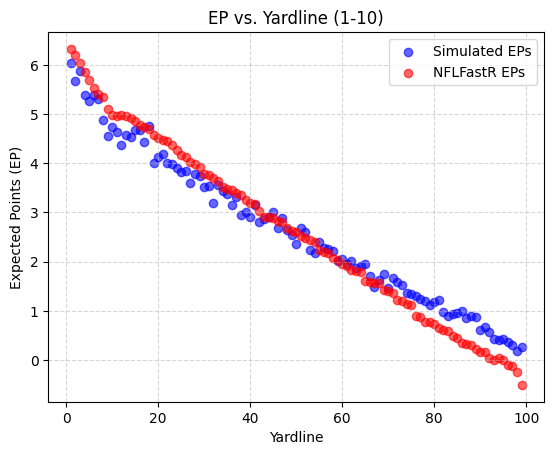

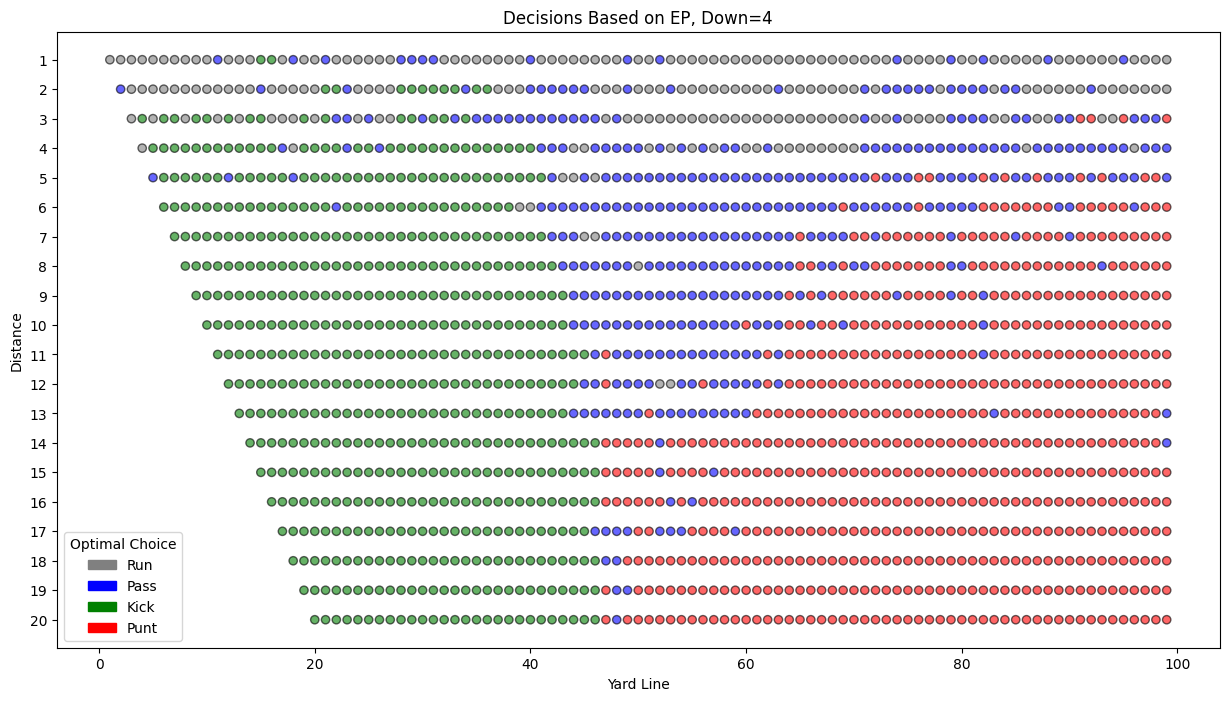

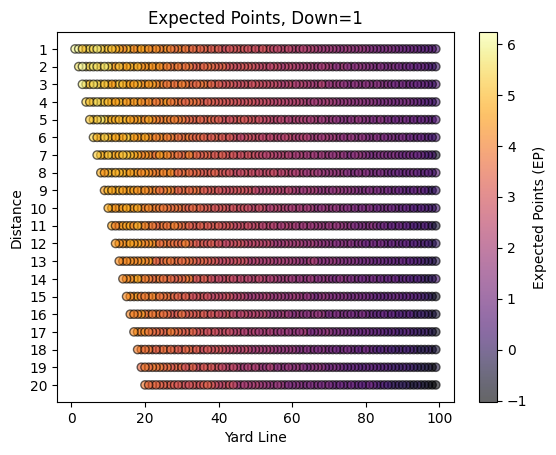

In [7]:
analyze_data('third_eps/max_eps.csv')
plt.show()
compare_eps('third_eps/max_eps.csv', 'nfl_pbp_data.csv')
plt.show()
predicted_decisions('third_eps/opt_choices.csv')
plt.show()
ep_visualizer('third_eps/max_eps.csv')
plt.show()

### NFL EP Data

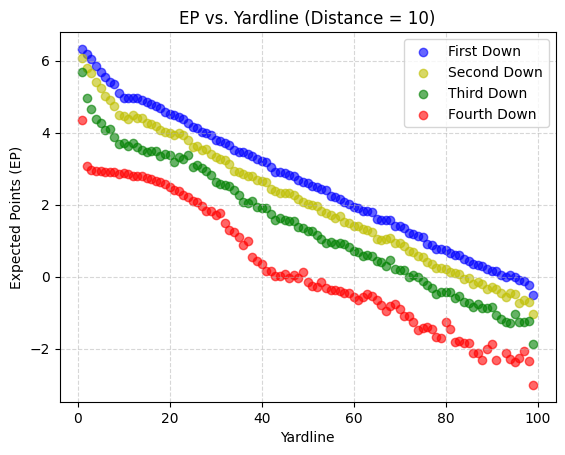

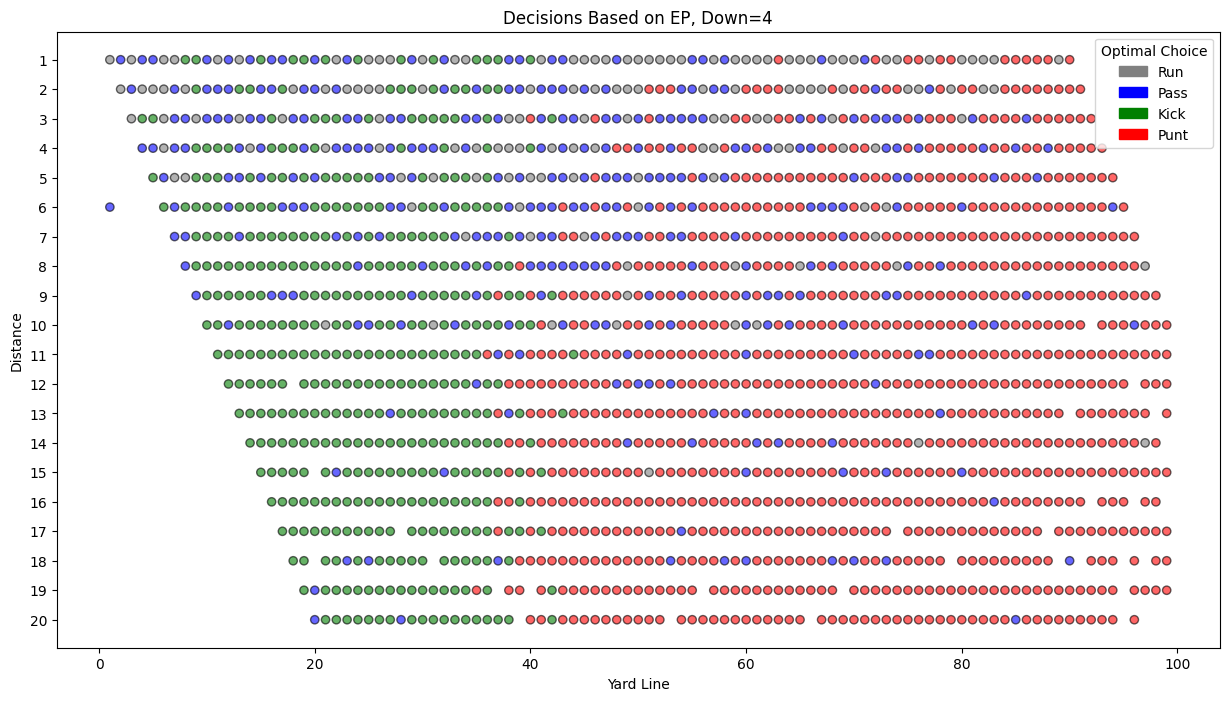

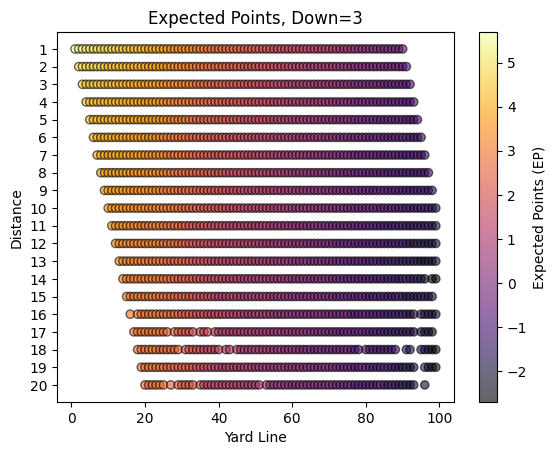

In [10]:
analyze_data('nfl_pbp_data.csv')
plt.show()
predicted_decisions('optimal_play_types.csv')
plt.show()
ep_visualizer('nfl_pbp_data.csv', down = 3)
plt.show()